In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


horse   cat plane   cat


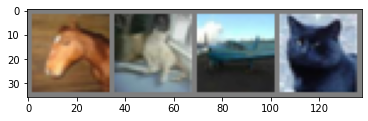

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# WAME IMPLEMENTATION

In [0]:
import torch
from torch.optim.optimizer import Optimizer


class WAME(Optimizer):
    """
        ETA -> n+, n-, RProp algo, pair of (etaminus, etaplis), that are multiplicative increase and decrease factors (default: (0.5, 1.2))
        Alpha -> RMSProp smoothing constant (default: 0.99)
        ZETA -> MIN, MAX, RProp a pair of minimal and maximal allowed step sizes (default: (1e-6, 50))
        LAMDA -> learning rate lr, RProp learning rate (default: 1e-2)

    """

    def __init__(self, params, lr=1e-2, etas=(0.1, 1.2), step_sizes=(0.01, 100), alpha=0.9, eps=1e-5, weight_decay=0, momentum=0, centered=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 < etas[0] < 1.0 < etas[1]:
            raise ValueError("Invalid eta values: {}, {}".format(etas[0], etas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= momentum:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= alpha:
            raise ValueError("Invalid alpha value: {}".format(alpha))

        defaults = dict(lr=lr, etas=etas, step_sizes=step_sizes, momentum=momentum, alpha=alpha, eps=eps, centered=centered, weight_decay=weight_decay)
        super(WAME, self).__init__(params, defaults)

        def __setstate__(self, state):
                  super(WAME, self).__setstate__(state)
                  for group in self.param_groups:
                    group.setdefault('momentum', 0)
                    group.setdefault('centered', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Rprop does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['prev'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['step_size'] = grad.new().resize_as_(grad).fill_(group['lr'])
                    state['square_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['EWMA'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    if group['momentum'] > 0:
                        state['momentum_buffer'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    if group['centered']:
                        state['grad_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                etaminus, etaplus = group['etas']
                step_size_min, step_size_max = group['step_sizes']
                step_size = state['step_size']

                square_avg = state['square_avg']
                EWMA = state['EWMA']
                alpha = group['alpha']
 
                state['step'] += 1

                sign = grad.mul(state['prev']).sign()
                sign[sign.gt(0)] = etaplus
                sign[sign.lt(0)] = etaminus
                sign[sign.eq(0)] = 1

                # update stepsizes with step size updates
                step_size.mul_(sign).clamp_(step_size_min, step_size_max)


                # for dir<0, dfdx=0
                # for dir>=0 dfdx=dfdx
                grad = grad.clone(memory_format=torch.preserve_format)
                grad[sign.eq(etaminus)] = 0
  

                EWMA.mul_(alpha).add_(step_size,alpha=1 - alpha)
                
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                       
                if group['centered']:
                    grad_avg = state['grad_avg']
                    grad_avg.mul_(alpha).add_(grad, alpha=1 - alpha)
                    avg = square_avg.addcmul(grad_avg, grad_avg, value=-1).sqrt_().add_(group['eps'])
                else:
                    avg = square_avg.sqrt().add_(group['eps'])
                
                if group['momentum'] > 0:
                    buf = state['momentum_buffer']
                    buf.mul_(group['momentum']).addcdiv_(grad, avg)
                    p.add_(buf, alpha=-group['lr'])
                else:
                    EWMA_avg = torch.div(step_size, EWMA)
                    num = torch.mul(EWMA_avg, grad)
                    p.addcdiv_(num, avg, value=-group['lr'])
                
                # update parameters

                state['prev'].copy_(grad)

        return loss

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = WAME(net.parameters(), lr=1e-4, etas=(0.1, 1.2), step_sizes=(0.01, 100),alpha=0.9, eps=1e-5, weight_decay=0, momentum=0, centered=False)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.091
[1,  4000] loss: 1.936
[1,  6000] loss: 1.834
[1,  8000] loss: 1.781
[1, 10000] loss: 1.739
[1, 12000] loss: 1.688
[2,  2000] loss: 1.640
[2,  4000] loss: 1.621
[2,  6000] loss: 1.582
[2,  8000] loss: 1.569
[2, 10000] loss: 1.539
[2, 12000] loss: 1.527
Finished Training


GroundTruth:    cat  ship  ship plane


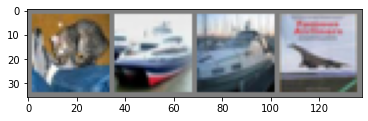

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship  ship  ship


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 45 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 64 %
Accuracy of  bird : 11 %
Accuracy of   cat : 19 %
Accuracy of  deer : 37 %
Accuracy of   dog : 28 %
Accuracy of  frog : 58 %
Accuracy of horse : 67 %
Accuracy of  ship : 55 %
Accuracy of truck : 65 %
